In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchmetrics
from torchmetrics.classification import MultilabelAUROC

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import libraries

# data manipulation
import pandas as pd
import numpy as np
import math

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from matplotlib import rc
from pylab import rcParams


# text processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


# pytorch
import torch
import torchtext
from torchtext.data import get_tokenizer
import torch.nn as nn
from torch.optim import Adam, SGD, Adagrad
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

# from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter


%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

tokenizer = get_tokenizer("spacy")

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.8/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


# Build Model

Tokens -> Build vocab -> embedding -> Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
df = pd.read_csv('./drive/MyDrive/NLP_project/tokenized.csv')
df.dropna(inplace=True)

In [ ]:
df.head()

,tokens,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation Why edits made username Hardcore M...,0,0,0,0,0,0
1,D aww He match background colour I seemingly s...,0,0,0,0,0,0
2,Hey man I really trying edit war It guy consta...,0,0,0,0,0,0
3,More I make real suggestion improvement I wond...,0,0,0,0,0,0
4,You sir hero Any chance remember page,0,0,0,0,0,0


In [ ]:
def get_word2int(df):

  words = ' '.join(df.tokens.values)
  words = words.split()
  counter = Counter(words)
  vocab = sorted(counter, key=counter.get, reverse=True)
  int2word = dict(enumerate(vocab, 1))
  int2word[0] = '<PAD>'
  word2int = {word: id for id, word in int2word.items()}

  return word2int

def simple_encode(comment):
    array = [word2int[word] for word in comment.split()]

    def pad_features(comment, pad_id=word2int["<PAD>"], seq_length=128):
      features = np.full((seq_length), pad_id, dtype=int)
      features[:len(comment)] = np.array(comment)[:seq_length]

      return features

    return pad_features(array, word2int['<PAD>'], 256) 



In [ ]:
word2int = get_word2int(df)

In [ ]:
df2 = df.copy()
df2['tokens'] = df.tokens.progress_apply(simple_encode)

100%|██████████| 159530/159530 [00:03<00:00, 48474.61it/s]


In [ ]:
df2.head()

,tokens,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[13038, 166, 58, 59, 554, 10390, 13919, 2543, ...",0,0,0,0,0,0
1,"[473, 23928, 118, 1022, 428, 2831, 1, 4302, 25...",0,0,0,0,0,0
2,"[433, 376, 1, 69, 164, 19, 269, 12, 279, 2127,...",0,0,0,0,0,0
3,"[1305, 1, 23, 262, 638, 1308, 1, 5724, 38, 236...",0,0,0,0,0,0
4,"[10, 2860, 3112, 806, 837, 562, 3, 0, 0, 0, 0,...",0,0,0,0,0,0


In [ ]:
train_df, val_df = train_test_split(df2, test_size=0.05)
print('training :', train_df.shape)
print('validation :', val_df.shape)

training : (151553, 7)
validation : (7977, 7)


In [ ]:
LABEL_COLUMNS = df2.columns.tolist()[1:]

In [ ]:
train_df.head()

,tokens,toxic,severe_toxic,obscene,threat,insult,identity_hate
103705,"[505, 90, 174, 396, 153, 449, 0, 0, 0, 0, 0, 0...",0,0,0,0,0,0
158019,"[9310, 683, 326, 1905, 3, 108, 9565, 0, 0, 0, ...",0,0,0,0,0,0
148179,"[192603, 24895, 128, 40554, 1, 420, 144, 443, ...",0,0,0,0,0,0
140228,"[7432, 8205, 1, 113, 306, 980, 12, 1099, 1882,...",0,0,0,0,0,0
97105,"[4030, 598, 1, 156, 58, 268, 33054, 3, 10864, ...",0,0,0,0,0,0


In [ ]:
train_x = np.array([x.astype(np.float32) for x in train_df.tokens.values])
train_y = train_df.iloc[:,1:].values.astype(np.float32)

val_x = np.array([x.astype(np.float32) for x in val_df.tokens.values])
val_y = val_df.iloc[:,1:].values.astype(np.float32)


In [ ]:
# define batch size
batch_size = 64

# create tensor datasets
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))

# create dataloaders
train_loader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(validset, shuffle=True, batch_size=batch_size)


In [ ]:
# check our batches
dataiter = iter(train_loader)
x, y = next(dataiter)

print('Sample batch size: ', x.size())   # batch_size, seq_length
print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())   # batch_size
print('Sample label input: \n', y)

Sample batch size:  torch.Size([64, 256])
Sample batch input: 
 tensor([[3.6800e+02, 2.2700e+02, 1.6300e+03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.1000e+01, 1.9483e+05, 1.5490e+03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.0360e+03, 3.2000e+01, 3.5300e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [4.0000e+00, 3.7512e+04, 2.7507e+04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.3911e+04, 2.6000e+01, 3.9700e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.3380e+03, 3.6180e+03, 6.5180e+03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

Sample label size:  torch.Size([64, 6])
Sample label input: 
 tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
     

In [ ]:
# model architecture

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(SentimentModel, self).__init__()

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)

        # LSTM layer preserved by PyTorch library
        self.rnn = nn.RNN(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer cz we will have binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        # convert feature to long
        x = x.long()

        # map input to vector
        x = self.embedding(x)

        # pass forward to lstm
        o, _ =  self.rnn(x)

        # get last sequence output
        o = o[:, -1, :]

        # apply dropout and fully connected layer
        o = self.dropout(o)
        o = self.fc(o)

        # sigmoid
        o = self.sigmoid(o)

        return o

In [ ]:
# model hyperparamters
vocab_size = len(word2int)
output_size = 6
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout=0.25

# model initialization
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout).to(device)
print(model)

SentimentModel(
  (embedding): Embedding(199989, 256, padding_idx=0)
  (rnn): RNN(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=6, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
loss_test = torch.nn.BCELoss()

test_x = torch.tensor([0.9, 0.02]).to(torch.float32)
test_target = torch.tensor([1, 0]).to(torch.float32)

loss_test(test_x, test_target)

tensor(0.0628)

In [ ]:
from sklearn.metrics import accuracy_score
import gc


def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    target_names = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in tqdm(val_loader):
            X, Y = X.to(device), Y.to(device)

            preds = model(X).to(torch.float32)
            Y = Y.to(torch.float32)

            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds)
            
        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)


        out = (Y_preds > 0.5).float() * 1
        tns, fps, fns, tps = 0, 0, 0, 0

        for i in range(6):
          tn, fp, fn, tp = confusion_matrix(Y_shuffled[:,i].cpu(), 
                                            out[:, i].cpu()).ravel()

          tns += tn
          fps += fp
          fns += fn
          tps += tp

          del tn, fp, fn, tp
        precision = tps / (tps + fps)
        recall = tps / (tps + fns)
        f1 = 2 * (precision * recall) / (precision + recall)

        auc = MultilabelAUROC(num_labels=6, average="macro", thresholds=None).to(device)

        print("Valid Loss : {:.3f} | Valid Acc : {:.3f} | Valid F1 : {:.3f} | Valid AUC : {:.3f}" .format(
            torch.tensor(losses).mean(), (tps+tns)/(tns+fps+fns+tps), f1, auc(out, Y_shuffled)))
  
        del precision, recall, f1

        return Y_shuffled, out, torch.tensor(losses).mean(), (tps+tns)/(tns+fps+fns+tps)

def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):

    epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc = [], [], [], []

    for i in range(1, epochs+1):
        print("Epochs : {}".format(i))
        Y_shuffled, Y_preds, losses= [],[],[]
        for X, Y in tqdm(train_loader):
            X, Y = X.to(device), Y.to(device)

            preds = model(X)

            Y = Y.to(torch.float32)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)


        tns, fps, fns, tps = 0, 0, 0, 0

        out = (Y_preds > 0.5).float() * 1
        for i in range(6):
          tn, fp, fn, tp = confusion_matrix(Y_shuffled[:,i].cpu().detach().numpy(), 
                                            out[:, i].cpu().detach().numpy()).ravel()

          tns += tn
          fps += fp
          fns += fn
          tps += tp

          del tn, fp, fn, tp
        precision = tps / (tps + fps)
        recall = tps / (tps + fns)
        f1 = 2 * (precision * recall) / (precision + recall)

        auc = MultilabelAUROC(num_labels=6, average="macro", thresholds=None).to(device)

        print("Train Loss : {:.3f} | Train Acc : {:.3f} | Train F1 : {:.3f} | Train AUC : {:.3f}" .format(
            torch.tensor(losses).mean(), (tps+tns)/(tns+fps+fns+tps), f1, auc(out, Y_shuffled)))

        _, _, val_loss, val_acc = CalcValLossAndAccuracy(model, loss_fn, val_loader)
        print("-"*80)
        
        del precision, recall, f1

        epoch_tr_loss.append(torch.tensor(losses).mean())
        epoch_tr_acc.append((tps+tns)/(tns+fps+fns+tps))
        epoch_vl_loss.append(val_loss)
        epoch_vl_acc.append(val_acc)
      
    return [epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc]

In [ ]:
from torch.optim import Adam

epochs = 15
learning_rate = 1e-3

loss_fn = torch.nn.BCELoss().to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

graph = TrainModel(model, 
                   loss_fn, 
                   optimizer, 
                   train_loader, 
                   val_loader, 
                   epochs)

Epochs : 1


100%|██████████| 2369/2369 [02:20<00:00, 16.85it/s]


Train Loss : 0.222 | Train Acc : 0.924 | Train F1 : 0.029 | Train AUC : 0.499


100%|██████████| 125/125 [00:01<00:00, 67.68it/s]


Valid Loss : 0.172 | Valid Acc : 0.955 | Valid F1 : 0.001 | Valid AUC : 0.498
--------------------------------------------------
Epochs : 2


100%|██████████| 2369/2369 [02:20<00:00, 16.91it/s]


Train Loss : 0.157 | Train Acc : 0.963 | Train F1 : 0.001 | Train AUC : 0.500


100%|██████████| 125/125 [00:01<00:00, 66.93it/s]


Valid Loss : 0.151 | Valid Acc : 0.962 | Valid F1 : nan | Valid AUC : 0.500
--------------------------------------------------
Epochs : 3


100%|██████████| 2369/2369 [02:19<00:00, 16.94it/s]


Train Loss : 0.146 | Train Acc : 0.963 | Train F1 : nan | Train AUC : 0.500


100%|██████████| 125/125 [00:01<00:00, 66.21it/s]


Valid Loss : 0.154 | Valid Acc : 0.962 | Valid F1 : nan | Valid AUC : 0.500
--------------------------------------------------
Epochs : 4


100%|██████████| 2369/2369 [02:19<00:00, 16.99it/s]


Train Loss : 0.144 | Train Acc : 0.963 | Train F1 : 0.000 | Train AUC : 0.500


100%|██████████| 125/125 [00:01<00:00, 66.79it/s]


Valid Loss : 0.148 | Valid Acc : 0.962 | Valid F1 : nan | Valid AUC : 0.500
--------------------------------------------------
Epochs : 5


100%|██████████| 2369/2369 [02:19<00:00, 17.03it/s]


Train Loss : 0.144 | Train Acc : 0.963 | Train F1 : nan | Train AUC : 0.500


100%|██████████| 125/125 [00:01<00:00, 66.38it/s]


Valid Loss : 0.156 | Valid Acc : 0.962 | Valid F1 : nan | Valid AUC : 0.500
--------------------------------------------------
Epochs : 6


100%|██████████| 2369/2369 [02:18<00:00, 17.07it/s]


Train Loss : 0.145 | Train Acc : 0.963 | Train F1 : 0.001 | Train AUC : 0.500


100%|██████████| 125/125 [00:01<00:00, 67.48it/s]


Valid Loss : 0.151 | Valid Acc : 0.962 | Valid F1 : nan | Valid AUC : 0.500
--------------------------------------------------
Epochs : 7


100%|██████████| 2369/2369 [02:18<00:00, 17.06it/s]


Train Loss : 0.144 | Train Acc : 0.963 | Train F1 : 0.001 | Train AUC : 0.500


100%|██████████| 125/125 [00:01<00:00, 66.45it/s]


Valid Loss : 0.147 | Valid Acc : 0.962 | Valid F1 : nan | Valid AUC : 0.500
--------------------------------------------------
Epochs : 8


100%|██████████| 2369/2369 [02:18<00:00, 17.07it/s]


Train Loss : 0.144 | Train Acc : 0.963 | Train F1 : nan | Train AUC : 0.500


100%|██████████| 125/125 [00:01<00:00, 67.65it/s]


Valid Loss : 0.150 | Valid Acc : 0.962 | Valid F1 : nan | Valid AUC : 0.500
--------------------------------------------------
Epochs : 9


100%|██████████| 2369/2369 [02:18<00:00, 17.09it/s]


Train Loss : 0.144 | Train Acc : 0.963 | Train F1 : nan | Train AUC : 0.500


100%|██████████| 125/125 [00:01<00:00, 66.58it/s]


Valid Loss : 0.149 | Valid Acc : 0.962 | Valid F1 : nan | Valid AUC : 0.500
--------------------------------------------------
Epochs : 10


100%|██████████| 2369/2369 [02:18<00:00, 17.08it/s]


Train Loss : 0.144 | Train Acc : 0.963 | Train F1 : 0.000 | Train AUC : 0.500


100%|██████████| 125/125 [00:01<00:00, 67.31it/s]


Valid Loss : 0.149 | Valid Acc : 0.962 | Valid F1 : nan | Valid AUC : 0.500
--------------------------------------------------
Epochs : 11


100%|██████████| 2369/2369 [02:18<00:00, 17.08it/s]


Train Loss : 0.144 | Train Acc : 0.963 | Train F1 : nan | Train AUC : 0.500


100%|██████████| 125/125 [00:01<00:00, 66.77it/s]


Valid Loss : 0.148 | Valid Acc : 0.962 | Valid F1 : nan | Valid AUC : 0.500
--------------------------------------------------
Epochs : 12


100%|██████████| 2369/2369 [02:19<00:00, 16.94it/s]


Train Loss : 0.144 | Train Acc : 0.963 | Train F1 : nan | Train AUC : 0.500


100%|██████████| 125/125 [00:01<00:00, 68.02it/s]


Valid Loss : 0.147 | Valid Acc : 0.962 | Valid F1 : nan | Valid AUC : 0.500
--------------------------------------------------
Epochs : 13


100%|██████████| 2369/2369 [02:18<00:00, 17.04it/s]


Train Loss : 0.144 | Train Acc : 0.963 | Train F1 : nan | Train AUC : 0.500


100%|██████████| 125/125 [00:01<00:00, 66.14it/s]


Valid Loss : 0.148 | Valid Acc : 0.962 | Valid F1 : nan | Valid AUC : 0.500
--------------------------------------------------
Epochs : 14


100%|██████████| 2369/2369 [02:18<00:00, 17.10it/s]


Train Loss : 0.144 | Train Acc : 0.963 | Train F1 : nan | Train AUC : 0.500


100%|██████████| 125/125 [00:01<00:00, 67.64it/s]


Valid Loss : 0.147 | Valid Acc : 0.962 | Valid F1 : nan | Valid AUC : 0.500
--------------------------------------------------
Epochs : 15


100%|██████████| 2369/2369 [02:18<00:00, 17.12it/s]


Train Loss : 0.144 | Train Acc : 0.963 | Train F1 : nan | Train AUC : 0.500


100%|██████████| 125/125 [00:01<00:00, 66.62it/s]


Valid Loss : 0.154 | Valid Acc : 0.962 | Valid F1 : nan | Valid AUC : 0.500
--------------------------------------------------


In [ ]:
torch.save(model.state_dict(), './drive/MyDrive/NLP_project/word2int-model.pt')

In [ ]:
def get_prediction(comment):
  comment_enc = np.array([simple_encode(comment)])
  comment_enc = torch.tensor(comment_enc).to(device)

  model.eval()
  with torch.no_grad():
    pred = model(comment_enc)

  return pred

In [ ]:
get_prediction(df.tokens.iloc[55])

tensor([[0.0550, 0.0080, 0.0224, 0.0011, 0.0176, 0.0046]], device='cuda:0')

In [ ]:
df[df['toxic'] == 1].head(10)

,tokens,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,Hey talk What exclusive group WP TALIBANS good...,1,0,0,0,0,0
16,Bye Don look come think comming back Tosser,1,0,0,0,0,0
42,You gay antisemmitian Archangel WHite Tiger Me...,1,0,1,0,1,1
43,FUCK YOUR FILTHY MOTHER IN THE ASS DRY,1,0,1,0,1,0
44,I Sorry I sorry I screwed around someone talk ...,1,0,0,0,0,0
51,GET FUCKED UP GET FUCKEED UP GOT A DRINK THAT ...,1,0,1,0,0,0
55,Stupid peace shit stop deleting stuff asshole ...,1,1,1,0,1,0
56,Tony Sidaway obviously fistfuckee He love arm,1,0,1,0,1,0
58,My Band Page deletion You thought I gone Delet...,1,0,1,0,0,0


The model can only classify toxic label since its the marjority label, and the vocab that use for train is only word2int, which dosen't cointain the meaning of each word. Consequently, the model can not disstigure separate other label.

In [ ]:
epoch_tr_loss = graph[0]
epoch_vl_loss = graph[1]
epoch_tr_acc = graph[2]
epoch_vl_acc = graph[3]

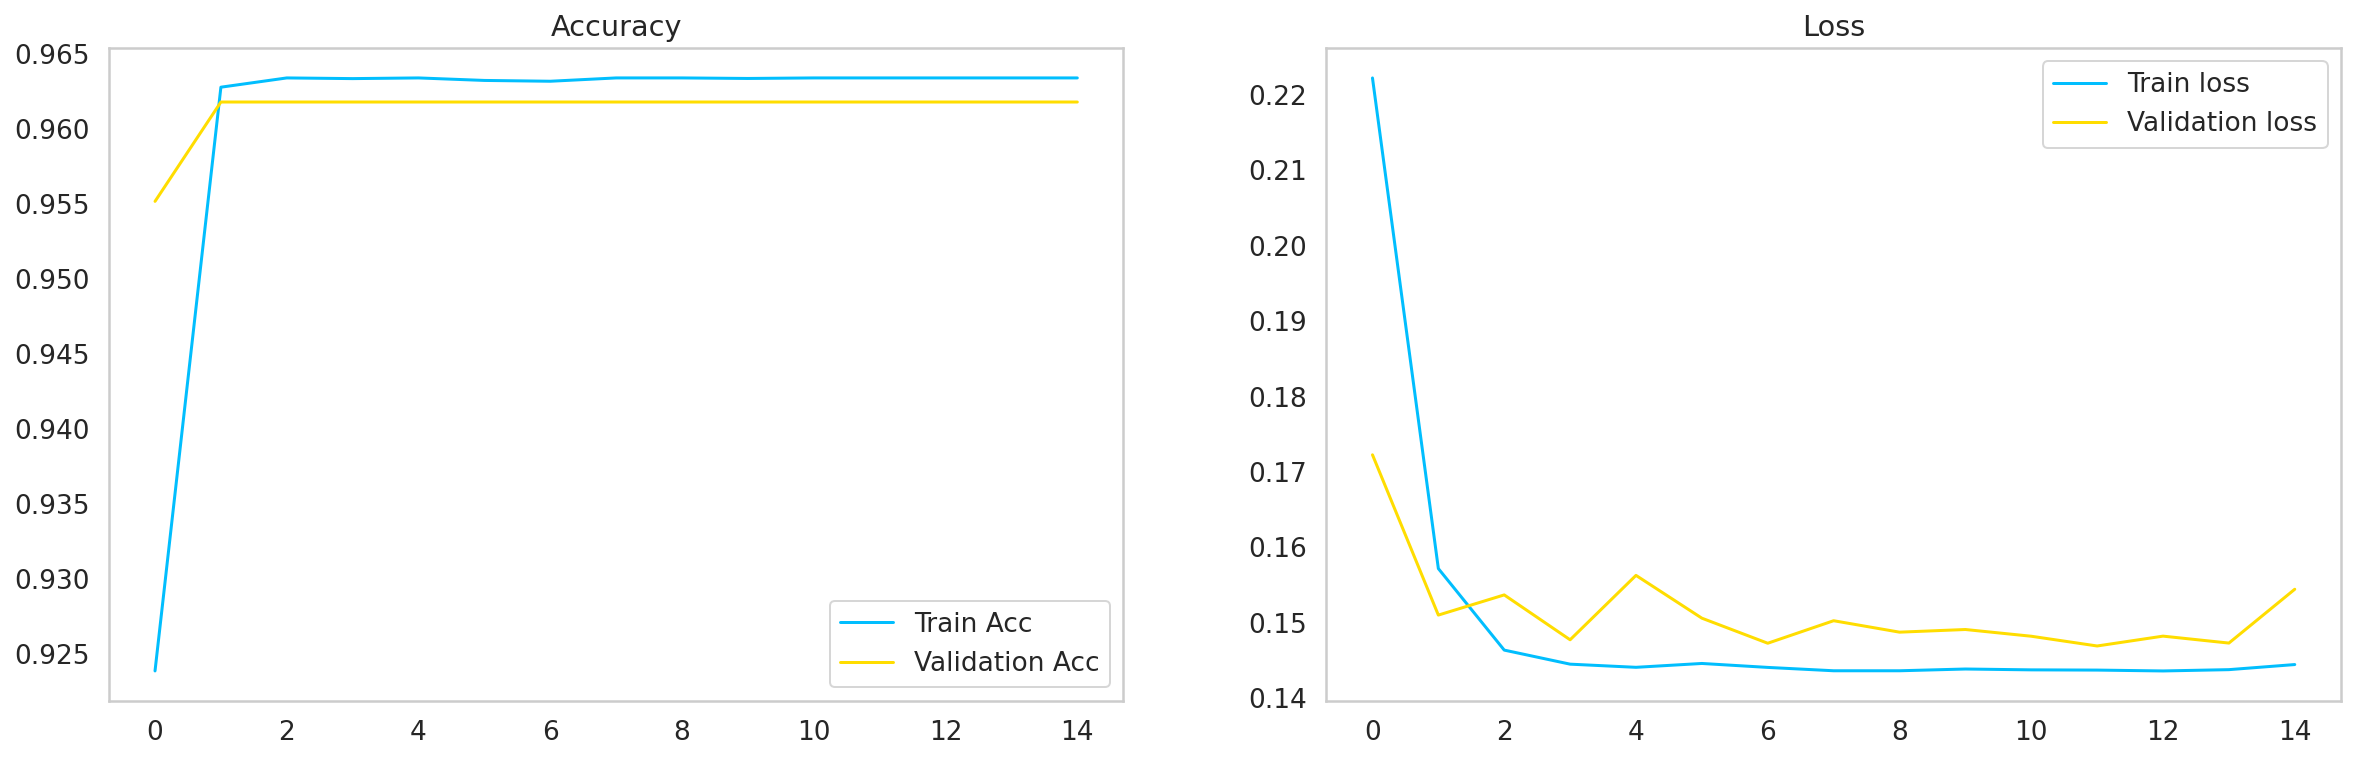

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()